In [1]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch
import torch
from diffusers import StableDiffusionPipeline
# Additional stuff from tutorial
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
device = 'cpu'
# 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.cuda.set_device(2)
print(f'Using device: {device}')

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
pipe.scheduler.set_timesteps(num_inference_steps=40)
#pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
#image_pipe.to(device);


Using device: cpu


Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Using custom data configuration Duskfallcrew--80sCartoons-b03dfcada786f961
Found cached dataset imagefolder (/home/agra2021/.cache/huggingface/datasets/Duskfallcrew___imagefolder/Duskfallcrew--80sCartoons-b03dfcada786f961/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Previewing batch:


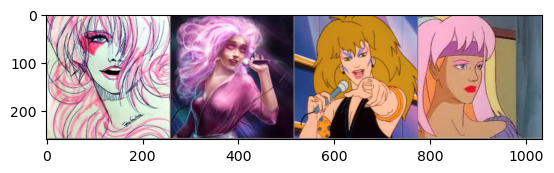

In [2]:
# @markdown load and prepare a dataset:
# Not on Colab? Comments with #@ enable UI tweaks like headings or user inputs
# but can safely be ignored if you're working on a different platform.

dataset_name = "Duskfallcrew/80sCartoons"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [8]:
num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param

optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    
        clean_images = batch["images"].to(device)
        print(f"Device used:  {clean_images.device}")
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        print(f"Device used: {noise.device}")
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = pipe.scheduler.add_noise(clean_images, noise, timesteps).to(clean_images.device)
        print(noisy_images.shape)
        #noisy_images = torch.swapaxes(noisy_images,0,1)
        #print(noisy_images.shape)

        print(f"Device used:  {noisy_images.device}")

        # Get the model prediction for the noise
        noise_pred = pipe.unet(noisy_images, timesteps, None, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

  0%|          | 0/68 [00:00<?, ?it/s]

Device used:  cpu
Device used: cpu
torch.Size([4, 3, 256, 256])
Device used:  cpu


RuntimeError: Given groups=1, weight of size [320, 4, 3, 3], expected input[4, 3, 256, 256] to have 4 channels, but got 3 channels instead

In [ ]:
pipe.to("cuda")
prompt = "a super hero on top of a building"
generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, guidance_scale=7.5, generator=generator).images[0]
image.save(f"alien_glasses2.png")
result = pipe(prompt)
print(result)